## Dataset

### Load dataset from Kaggle (uncomment if needed)

In [1]:
# !mkdir -p /root/.kaggle/
# !echo '{"username":"tibid94554sha","key":"57419f0675a80ab30fa664dc16a396bb"}' > /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [2]:
# !kaggle competitions download -c vehicle

In [ ]:
# !unzip -qq vehicle.zip

### Load dataset from Google Drive (uncomment if needed)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !cp /content/drive/MyDrive/vehicle.zip /content/vehicle.zip

In [6]:
# !unzip -qq vehicle.zip

### Save dataset to Google Drive (uncomment if needed)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# !cp /content/vehicle.zip /content/drive/MyDrive/vehicle.zip

### Check dataset exists

In [9]:
import os

# Путь к директории верхнего уровня
base_dir = 'train/train'

# Проверяем, существует ли директория
if not os.path.exists(base_dir):
    print(f"Директория {base_dir} не существует.")
else:
    # Получаем список всех объектов в директории
    subdirectories = os.listdir(base_dir)

    # Флаг для отслеживания наличия хотя бы одной непустой поддиректории
    found_non_empty = False

    for subdir in subdirectories:
        subdir_path = os.path.join(base_dir, subdir)

        # Проверяем, является ли объект директорией
        if os.path.isdir(subdir_path):
            # Проверяем, не пуста ли директория
            if not os.listdir(subdir_path):
                print(f"Директория {subdir_path} пуста.")
            else:
                print(f"В директории {subdir_path} есть файлы.")
                found_non_empty = True
        else:
            print(f"{subdir_path} не является директорией.")

    if not found_non_empty:
        print("Не найдены непустые поддиректории.")
        assert False


В директории train/train/Ambulance есть файлы.
В директории train/train/Barge есть файлы.
В директории train/train/Bicycle есть файлы.
В директории train/train/Boat есть файлы.
В директории train/train/Bus есть файлы.
В директории train/train/Car есть файлы.
В директории train/train/Cart есть файлы.
В директории train/train/Caterpillar есть файлы.
В директории train/train/Helicopter есть файлы.
В директории train/train/Limousine есть файлы.
В директории train/train/Motorcycle есть файлы.
В директории train/train/Segway есть файлы.
В директории train/train/Snowmobile есть файлы.
В директории train/train/Tank есть файлы.
В директории train/train/Taxi есть файлы.
В директории train/train/Truck есть файлы.
В директории train/train/Van есть файлы.


## Base imports

In [10]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Read data

In [11]:
import os

root_train = './train/train/'

data_train = []

for category in sorted(os.listdir(root_train)):
    for file in sorted(os.listdir(os.path.join(root_train, category))):
        data_train.append((category, os.path.join(root_train, category, file)))

print(f'Train data: {len(data_train)}')

Train data: 28045


### Create data frame

In [12]:
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder()

df = pd.DataFrame(data_train, columns=['class','file_path'])
df['class_'] = class_encoder.fit_transform(df['class'])

df.head()

,class,file_path,class_
0,Ambulance,./train/train/Ambulance/000040_09.jpg,0
1,Ambulance,./train/train/Ambulance/000050_10.jpg,0
2,Ambulance,./train/train/Ambulance/000052_03.jpg,0
3,Ambulance,./train/train/Ambulance/000057_04.jpg,0
4,Ambulance,./train/train/Ambulance/000067_14.jpg,0


### Decrease data frame

In [13]:
TEST_SIZE = 0.2
IMAGE_SIZE = 160
BATCH_SIZE = 32

CLASSES = ['Boat', 'Car', 'Motorcycle', 'Bus', 'Truck']
IMAGES_PER_CLASS = 200

In [14]:
def subset_classes(data, classes, max_per_class):
    result_df = pd.DataFrame()
    for cls in classes:
        class_subset = data[data['class'] == cls].head(max_per_class)
        result_df = pd.concat([result_df, class_subset])

    return result_df

new_df = subset_classes(df, CLASSES, IMAGES_PER_CLASS)
new_df.head()

,class,file_path,class_
1952,Boat,./train/train/Boat/000002_14.jpg,3
1953,Boat,./train/train/Boat/000003_04.jpg,3
1954,Boat,./train/train/Boat/000003_09.jpg,3
1955,Boat,./train/train/Boat/000004_03.jpg,3
1956,Boat,./train/train/Boat/000004_11.jpg,3


### Example image

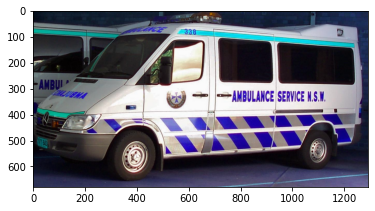

In [15]:
example_file_path = data_train[0][1]

img = cv2.imread(example_file_path)
plt.imshow(img)

### Wavelet transform

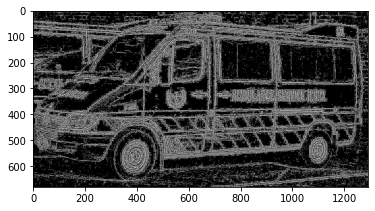

In [16]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img

    # Datatype conversions
    # convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)

    # convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;

    # compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    # Process Coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


im_har = w2d(img, 'db1', 1)
plt.imshow(im_har, cmap='gray')

## Statistics models

### Prepare data

In [17]:
from sklearn.model_selection import train_test_split

def load_and_prepare_img(file_path):
    img = cv2.imread(file_path)
    w2d_img = w2d(img, 'db1', 5)
    cmb_img = np.vstack((
        cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)).reshape(-1, 1),
        cv2.resize(w2d_img, (IMAGE_SIZE, IMAGE_SIZE)).reshape(-1, 1)
    ))
    return cmb_img.reshape(-1, 1).astype(np.float64)

def load_and_prepare(X_file_path):
    X = X_file_path.apply(load_and_prepare_img)
    return np.stack(X).reshape(len(X), -1)


X = load_and_prepare(new_df['file_path'])
y = new_df['class_']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Train test model

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf'))])
pipe.fit(X_train, y_train)
print('Accuracy: ', pipe.score(X_test, y_test))

Accuracy:  0.448


### Get best params and model

In [19]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1, 10, 100],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    }
}

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

models_df = pd.DataFrame(scores, columns=['model','best_score','best_params'])
models_df

,model,best_score,best_params
0,svm,0.460000,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.338667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.409333,{'logisticregression__C': 5}


In [21]:
print('SVM accuracy: ', best_estimators['svm'].score(X_test, y_test))

SVM accuracy:  0.464


In [22]:
print('RandomForest accuracy: ', best_estimators['random_forest'].score(X_test, y_test))

RandomForest accuracy:  0.328


In [23]:
print('LogisticRegression accuracy: ', best_estimators['logistic_regression'].score(X_test, y_test))

LogisticRegression accuracy:  0.44


### Visualization of the best model

Text(69.0, 0.5, 'Truth')

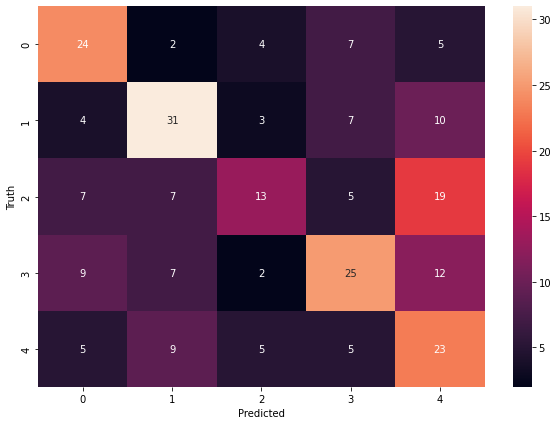

In [24]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

best_clf = best_estimators['svm']
cm = confusion_matrix(y_test, best_clf.predict(X_test))

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Deep learning models

### Prepare data

In [25]:
NUM_EPOCHS = 20

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = len(new_df['class_'].unique())
train_df, test_df = train_test_split(new_df, test_size=TEST_SIZE)

# Определяем параметры предварительной обработки и увеличения данных
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Нормализация
    rotation_range=20,      # Случайные повороты на 20 градусов
    width_shift_range=0.2,  # Случайные сдвиги по ширине
    height_shift_range=0.2, # Случайные сдвиги по высоте
    shear_range=0.2,        # Случайные сдвиги
    zoom_range=0.2,         # Случайные увеличения/уменьшения
    horizontal_flip=True,   # Случайные отражения по горизонтали
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Подготовка генераторов данных из директории
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./',
    x_col='file_path',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),   # Размер входных изображений
    batch_size=BATCH_SIZE,
    class_mode='categorical'                # для многоклассовой классификации
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='./',
    x_col='file_path',
    y_col='class',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


2024-05-10 12:52:49.104302: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 12:52:50.615135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 12:52:54.063175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.


### Utils

In [27]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def show_history(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    if model_name:
        plt.title(f'{model_name} Training and Validation Accuracy')
    else:
        plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    return plt.show()

def get_predictions_and_labels(model, generator):
    predictions = []
    labels = []
    for x, y in generator:
        p = model.predict(x)
        predictions.extend(np.argmax(p, axis=1))
        labels.extend(np.argmax(y, axis=1))
        if len(predictions) >= len(generator.filenames):
            break
    return predictions, labels

def show_confusion_matrix(model, generator, model_name=None):
    predictions, labels = get_predictions_and_labels(model, test_generator)
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize = (10, 7))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    if model_name:
        plt.title(f'{model_name} Confusion Matrix')
    else:
        plt.title('Confusion Matrix')
    plt.show()

def print_accuracy(model, generator, model_name=None):
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'{model_name} accuracy:', test_acc)


### Custom CNN model

#### Build model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # num_classes - кол-во классов транспортных средств
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

2024-05-10 12:53:02.550615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

#### Train model

2024-05-10 12:53:03.304997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.8091 - accuracy: 0.2188

2024-05-10 12:53:15.363636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 14s 502ms/step - loss: 1.8091 - accuracy: 0.2188 - val_loss: 1.5949 - val_accuracy: 0.3750
Epoch 2/20
25/25 [==============================] - 11s 453ms/step - loss: 1.5755 - accuracy: 0.2800 - val_loss: 1.5857 - val_accuracy: 0.3100
Epoch 3/20
25/25 [==============================] - 11s 458ms/step - loss: 1.5282 - accuracy: 0.2988 - val_loss: 1.5379 - val_accuracy: 0.3750
Epoch 4/20
25/25 [==============================] - 11s 458ms/step - loss: 1.5221 - accuracy: 0.3512 - val_loss: 1.5320 - val_accuracy: 0.3350
Epoch 5/20
25/25 [==============================] - 12s 461ms/step - loss: 1.4672 - accuracy: 0.3663 - val_loss: 1.4585 - val_accuracy: 0.4100
Epoch 6/20
25/25 [==============================] - 11s 453ms/step - loss: 1.4301 - accuracy: 0.3975 - val_loss: 1.3809 - val_accuracy: 0.4600
Epoch 7/20
25/25 [==============================] - 12s 468ms/step - loss: 1.3893 - accuracy: 0.4525 - val_loss: 1.4265 - val_accuracy: 0.3850
Epoch 8/20

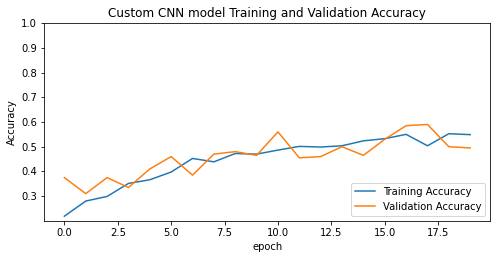

In [29]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator
)

show_history(cnn_history, model_name='Custom CNN model')

#### Visualization result

In [30]:
print_accuracy(cnn_model, test_generator, 'Custom CNN model')

2024-05-10 12:56:58.163872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 1s 194ms/step - loss: 1.1965 - accuracy: 0.4950
Custom CNN model accuracy: 0.4950000047683716


1/1 [==============================] - 0s 77ms/step


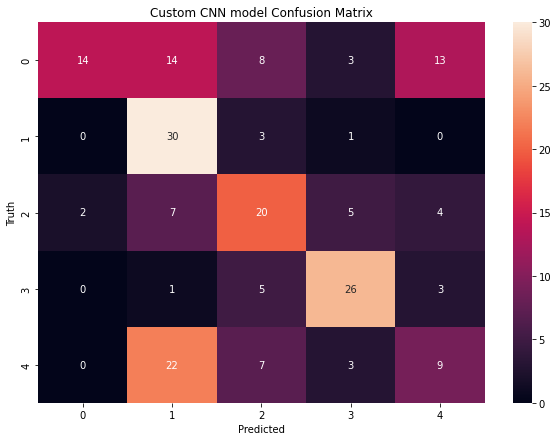

In [31]:
show_confusion_matrix(cnn_model, test_generator, 'Custom CNN model')

### Pretrained ResNet50 model

#### Build model

In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Загрузка предобученной модели ResNet50 без последнего слоя
res_net_50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Замораживаем веса предобученной основы модели
for layer in res_net_50_model.layers:
    layer.trainable = False

# Добавление новых слоев
x = res_net_50_model.output
x = GlobalAveragePooling2D()(x)                 # Добавляем глобальный средний слой пулинга
x = Dense(1024, activation='relu')(x)           # Полносвязный слой на 1024 нейрона с relu активацией
x = Dropout(0.5)(x)                             # Слой Dropout для борьбы с переобучением
predictions = Dense(num_classes, activation='softmax')(x) # Выходной слой на 5 классов

res_net_50_fine_tune_model = Model(inputs=res_net_50_model.input, outputs=predictions)

res_net_50_fine_tune_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

res_net_50_fine_tune_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']         

#### Train model

2024-05-10 12:57:08.921154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.7908 - accuracy: 0.2150

2024-05-10 12:57:22.552847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 16s 561ms/step - loss: 1.7908 - accuracy: 0.2150 - val_loss: 1.6051 - val_accuracy: 0.2300
Epoch 2/20
25/25 [==============================] - 13s 496ms/step - loss: 1.6528 - accuracy: 0.2387 - val_loss: 1.5472 - val_accuracy: 0.3600
Epoch 3/20
25/25 [==============================] - 13s 513ms/step - loss: 1.6128 - accuracy: 0.2612 - val_loss: 1.5519 - val_accuracy: 0.2700
Epoch 4/20
25/25 [==============================] - 13s 506ms/step - loss: 1.5772 - accuracy: 0.2825 - val_loss: 1.5903 - val_accuracy: 0.2950
Epoch 5/20
25/25 [==============================] - 13s 503ms/step - loss: 1.5528 - accuracy: 0.3100 - val_loss: 1.5366 - val_accuracy: 0.3250
Epoch 6/20
25/25 [==============================] - 13s 504ms/step - loss: 1.5305 - accuracy: 0.3175 - val_loss: 1.5258 - val_accuracy: 0.3400
Epoch 7/20
25/25 [==============================] - 13s 516ms/step - loss: 1.5285 - accuracy: 0.3100 - val_loss: 1.5095 - val_accuracy: 0.3750
Epoch 8/20

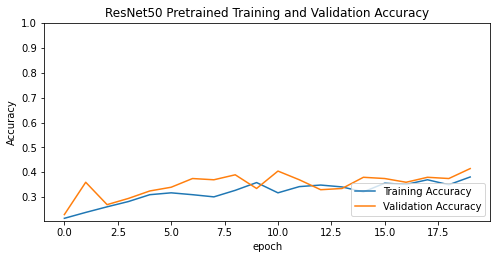

In [33]:
res_net_50_fine_tune_history = res_net_50_fine_tune_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator
)
show_history(res_net_50_fine_tune_history, 'ResNet50 Pretrained')

#### Visualization result

In [34]:
print_accuracy(res_net_50_fine_tune_model, test_generator, 'ResNet50 Pretrained')

2024-05-10 13:01:30.369708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 2s 250ms/step - loss: 1.4379 - accuracy: 0.4150
ResNet50 Pretrained accuracy: 0.41499999165534973


1/1 [==============================] - 1s 710ms/step


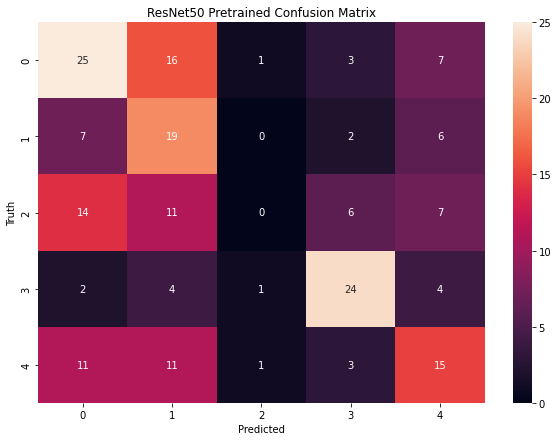

In [35]:
show_confusion_matrix(res_net_50_fine_tune_model, test_generator, 'ResNet50 Pretrained')

### Pretrained MobileNetV2 model

#### Build model

In [36]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Загрузка предобученной модели MobileNetV2 без последнего слоя
mobile_net_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Замораживаем веса предобученной модели
for layer in mobile_net_v2_model.layers:
    layer.trainable = False

# Добавление новых слоев
x = mobile_net_v2_model.output
x = GlobalAveragePooling2D()(x)                            # Добавляем глобальный средний слой пулинга
x = Dense(1024, activation='relu')(x)                      # Полносвязный слой на 1024 нейрона с relu активацией
x = Dropout(0.5)(x)                                        # Слой Dropout для борьбы с переобучением
predictions = Dense(num_classes, activation='softmax')(x)  # Выходной слой на 5 классов

mobile_net_v2_fine_tune_model = Model(inputs=mobile_net_v2_model.input, outputs=predictions)

mobile_net_v2_fine_tune_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

mobile_net_v2_fine_tune_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']         

#### Train model

2024-05-10 13:01:38.960861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.1278 - accuracy: 0.6538

2024-05-10 13:01:51.270833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 14s 497ms/step - loss: 1.1278 - accuracy: 0.6538 - val_loss: 0.6375 - val_accuracy: 0.7900
Epoch 2/20
25/25 [==============================] - 11s 442ms/step - loss: 0.5797 - accuracy: 0.8062 - val_loss: 0.5605 - val_accuracy: 0.8050
Epoch 3/20
25/25 [==============================] - 11s 447ms/step - loss: 0.5413 - accuracy: 0.8037 - val_loss: 0.4533 - val_accuracy: 0.8450
Epoch 4/20
25/25 [==============================] - 11s 443ms/step - loss: 0.4380 - accuracy: 0.8550 - val_loss: 0.5422 - val_accuracy: 0.8250
Epoch 5/20
25/25 [==============================] - 11s 439ms/step - loss: 0.3811 - accuracy: 0.8587 - val_loss: 0.4791 - val_accuracy: 0.8400
Epoch 6/20
25/25 [==============================] - 11s 439ms/step - loss: 0.3183 - accuracy: 0.8875 - val_loss: 0.4705 - val_accuracy: 0.8300
Epoch 7/20
25/25 [==============================] - 11s 450ms/step - loss: 0.3838 - accuracy: 0.8575 - val_loss: 0.4182 - val_accuracy: 0.8550
Epoch 8/20

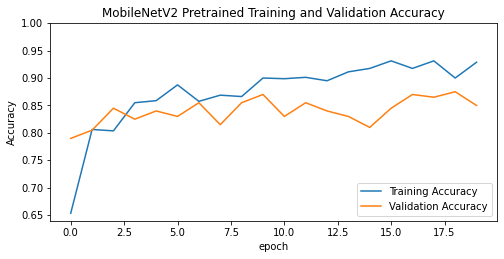

In [37]:
mobile_net_v2_fine_tune_history = mobile_net_v2_fine_tune_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator
)
show_history(mobile_net_v2_fine_tune_history, 'MobileNetV2 Pretrained')

#### Visualization result

In [38]:
print_accuracy(mobile_net_v2_fine_tune_model, test_generator, 'MobileNetV2 Pretrained')

2024-05-10 13:05:26.986095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 2s 190ms/step - loss: 0.4462 - accuracy: 0.8500
MobileNetV2 Pretrained accuracy: 0.8500000238418579


1/1 [==============================] - 1s 554ms/step


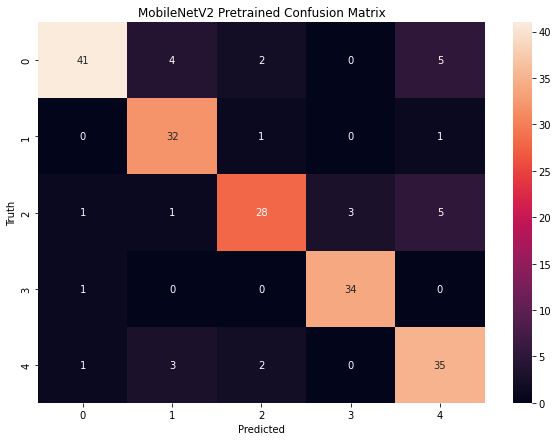

In [39]:
show_confusion_matrix(mobile_net_v2_fine_tune_model, test_generator, 'MobileNetV2 Pretrained')